In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ryanholbrook/car-or-truck")

print("Path to dataset files:", path)

/home/dnilson/Documentos/PROJETOS/kaggle/computer-vision/the-convolutional-classifier/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/dnilson/.cache/kagglehub/datasets/ryanholbrook/car-or-truck/versions/1


### Introduction

In [3]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import gridspec

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    str(path) + '/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    str(path) + '/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [38]:
# Load model pre-trained
import tensorflow_hub as hub

pretrained_base = hub.KerasLayer("https://www.kaggle.com/models/google/inception-v1/TensorFlow2/classification/2")

# 2) Attach Head #

Now that the base is defined to do the feature extraction, create a head of `Dense` layers to perform the classification, following this diagram:

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/i5VU7Ry.png" alt="Diagram of the dense head.">
</figure>


In [40]:
# Import TensorFlow Compatability
import tf_keras

model = tf_keras.Sequential([
    pretrained_base,
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(6, activation="relu"),
    tf_keras.layers.Dense(1, activation="sigmoid"),
])

# 3) Train

In [50]:
optimizer = tf_keras.optimizers.Adam(epsilon=0.01)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=35,
)

Epoch 1/35
80/80 [==============================] - 20s 238ms/step - loss: 0.2869 - binary_accuracy: 0.8755 - val_loss: 0.3629 - val_binary_accuracy: 0.8458
Epoch 2/35
80/80 [==============================] - 19s 243ms/step - loss: 0.2836 - binary_accuracy: 0.8759 - val_loss: 0.3640 - val_binary_accuracy: 0.8485
Epoch 3/35
80/80 [==============================] - 21s 259ms/step - loss: 0.2816 - binary_accuracy: 0.8741 - val_loss: 0.3643 - val_binary_accuracy: 0.8491
Epoch 4/35
80/80 [==============================] - 20s 248ms/step - loss: 0.2769 - binary_accuracy: 0.8777 - val_loss: 0.3656 - val_binary_accuracy: 0.8489
Epoch 5/35
80/80 [==============================] - 20s 247ms/step - loss: 0.2723 - binary_accuracy: 0.8798 - val_loss: 0.3648 - val_binary_accuracy: 0.8509
Epoch 6/35
80/80 [==============================] - 19s 240ms/step - loss: 0.2684 - binary_accuracy: 0.8818 - val_loss: 0.3683 - val_binary_accuracy: 0.8485
Epoch 7/35
80/80 [==============================] - 20s 25

# 4) Results

<Axes: >

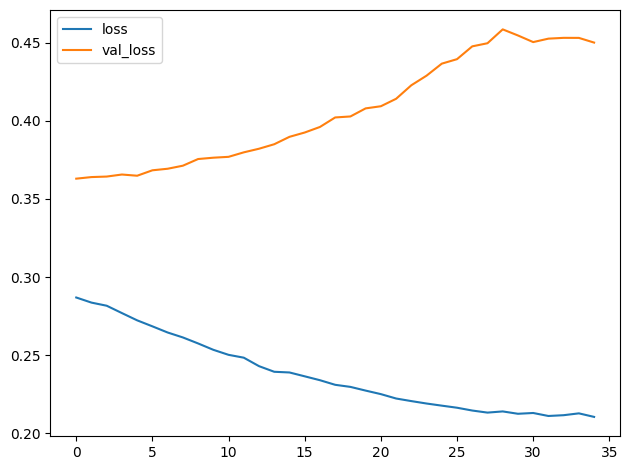

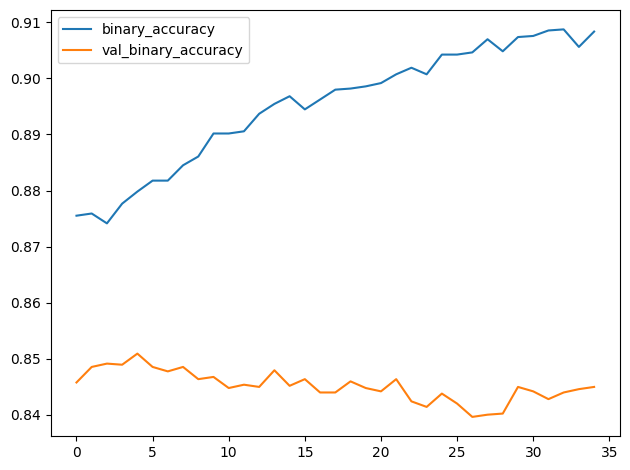

In [52]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()